In [1]:
from gs_quant.session import Environment, GsSession
from gs_quant.instrument import IRSwaption
from gs_quant.markets.portfolio import Portfolio
from gs_quant.markets import PricingContext
from gs_quant.risk import CarryScenario
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(Environment.PROD, client_id=None, client_secret=None, scopes=('run_analytics',))

In [3]:
# basic usage of carry scenario
eur1y10y = IRSwaption('Pay', '10y', 'EUR', expiration_date='1y')

# care needs to be taken when creating relative trades like the one above.  
# If you don't resolve the trade, the resolution of the trade parameters will be done with 
# reference to the active pricing context.  Under the carry scenario this means that
# if you don't resolve the trade will be a different trade when priced under the carry scenario.
eur1y10y.resolve()

# Shift forward 22 business days (1 month)
carry_scenario = CarryScenario(time_shift=22)
with carry_scenario:
    fwd_price = eur1y10y.price()

print('Base price:     {:,.2f}'.format(eur1y10y.price()))
print('Scenario price: {:,.2f}'.format(fwd_price))

Base price:     1,924,029.44
Scenario price: 1,792,373.79


Text(0, 0.5, 'PV')

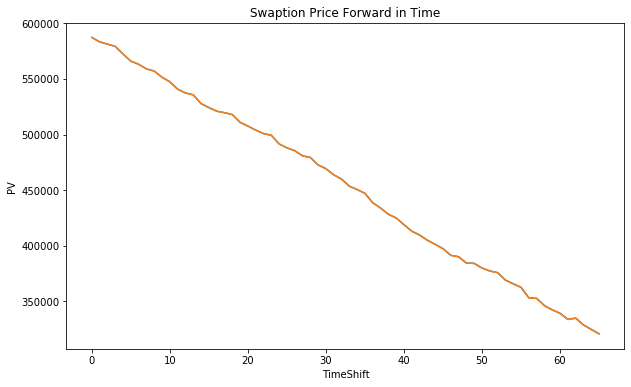

In [4]:
# show how the option value will roll down moving forward 66 business days assuming either fwds 
# or spot rates are realised.

short_swaption = IRSwaption('Pay', '5y', 'USD', expirationDate='6m', notionalAmount=1e8)
short_swaption.resolve()

prices = []
roll_spot_prices = []
with PricingContext():
    for time_shift in range(66):
        with CarryScenario(time_shift=time_shift, roll_to_fwds=True):
            prices.append(short_swaption.price())
        with CarryScenario(time_shift=time_shift, roll_to_fwds=False):
            roll_spot_prices.append(short_swaption.price())

pd.Series([p.result() for p in prices], dtype=np.dtype(float)).plot(figsize=(10, 6),
                                                                    title="Swaption Price Forward in Time", 
                                                                    label='roll to fwd')
pd.Series([rp.result() for rp in roll_spot_prices], dtype=np.dtype(float)).plot(figsize=(10, 6), 
                                                       label='roll to spot')
plt.xlabel('TimeShift')
plt.ylabel('PV')

In [7]:
# create a grid of expiry by tenor swaptions showing the pv under the carry scenario minus the base pv.
def calc_risk_matrix(ccy, strike, pay_rec, time_shift, roll_to_fwds, expiries, tenors):
    portfolio = Portfolio([IRSwaption(pay_rec, tenor, ccy,
                                      expiration_date=expiry, strike=strike, name='{}_{}'.format(expiry, tenor)) 
                          for expiry in expiries for tenor in tenors])
    portfolio.resolve()
    with CarryScenario(time_shift=time_shift, roll_to_fwds=roll_to_fwds):
        carry_results = portfolio.price()
    
    base_results = portfolio.price()
    
    carry_records = [(carry_results[t]-base_results[t], t.name.split('_')[0], t.name.split('_')[1]) for t in portfolio]
    carry_df = pd.DataFrame(carry_records, columns=['Value', 'Expiry', 'Tenor'])
    
    pivot_df = carry_df.pivot_table(values='Value', index='Expiry', columns='Tenor')
    return pivot_df[tenors].reindex(expiries)

In [8]:
ccy = 'EUR'
strike = 'ATM'
pay_rec = 'Pay'  # or 'Receive' or 'Straddle'
time_shift = 22  # in business days for carry scenario
roll_to_fwds = True
expiries = ['1m', '2m', '3m', '6m', '9m', '1y', '18m', '2y', '3y', '5y', '7y', '10y']
tenors = ['1m', '3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y', '15y', '20y', '25y', '30y']

calc_risk_matrix(ccy, strike, pay_rec, time_shift, roll_to_fwds, expiries, tenors)

KeyError: '1m_1m (IRSwaption) not in portfolio'